In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from pathlib import Path

# directory and file paths
data_dir = Path("../data/")
interim_data_dir = data_dir / "interim"
processed_data_dir = data_dir / "processed"

interim_mortgage_file = interim_data_dir / "CountyMortgagesPercent-30-89DaysLate-thru-2020-09.csv"
interim_msa_file = interim_data_dir / "cbsatocountycrosswalk.csv"


In [120]:
mortgage_delinq_df = pd.read_csv(interim_mortgage_file)
mortgage_delinq_df = pd.concat([mortgage_delinq_df.iloc[:,0:4],mortgage_delinq_df.iloc[:,-21:]],axis = 1)
mortgage_delinq_df = mortgage_delinq_df[mortgage_delinq_df['State'].notna()]
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].str.replace("'",'')
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].astype(int)
mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
1,County,AL,Baldwin County,1003,2.5,2.1,2.0,1.8,2.1,2.6,...,2.5,2.7,1.7,1.7,1.0,1.1,1.1,1.2,0.8,0.8
2,County,AL,Jefferson County,1073,3.6,3.1,2.9,2.5,2.7,2.6,...,3.5,3.7,3.0,2.6,1.8,1.5,1.4,1.3,1.4,1.2
3,County,AL,Lee County,1081,2.8,2.4,2.0,1.7,1.5,1.0,...,2.6,2.7,2.0,2.3,0.9,0.7,0.6,0.6,0.7,0.5
4,County,AL,Madison County,1089,2.2,2.3,2.0,1.7,1.7,1.9,...,2.2,2.2,1.5,1.8,1.0,1.0,0.7,0.8,1.0,0.9
5,County,AL,Mobile County,1097,3.7,3.8,3.8,3.2,3.4,3.2,...,3.8,3.9,3.5,3.6,2.4,1.8,2.0,1.9,1.9,1.6


In [64]:
msa_df = pd.read_csv(interim_msa_file)
msa_df = msa_df.iloc[:,0:9]
msa_df.head()

,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname
0,AUTAUGA,AL,1000,1001,5240.0,NaN,"MONTGOMERY, AL",33860.0,"Montgomery, AL"
1,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN
2,BARBOUR,AL,1020,1005,1.0,NaN,ALABAMA,NaN,NaN
3,BIBB,AL,1030,1007,1.0,NaN,ALABAMA,13820.0,"Birmingham-Hoover, AL"
4,BLOUNT,AL,1040,1009,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL"


In [97]:
mortgage_delinq_df = pd.merge(mortgage_delinq_df, 
                              msa_df, 
                              left_on=['State','FIPSCode'], 
                              right_on = ['state','fipscounty'])

In [99]:
northeast = ["PA", "VT", "ME", "RI", "NY", "CT", "NH", "ME", "NJ", "MA"] 
midwest = ["OH", "IN", "IL", "MI", "WI", "MO", "IA", "MN", "KS", "NE", "SD", "ND"]
west = ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "CO", "NM", "AZ", "UT", "AK", "HI"]
south = ["MD", "DE", "DC", "WV", "VA", "NC", "KY", "TN", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

conditions = [
    (mortgage_delinq_df['State'].isin(northeast)),
    (mortgage_delinq_df['State'].isin(midwest)),
    (mortgage_delinq_df['State'].isin(west)),
    (mortgage_delinq_df['State'].isin(south))
    ]

regions = ['Northeast', 'Midwest', 'West', 'South']

mortgage_delinq_df['Region'] = np.select(conditions, regions)

mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,...,cbsaname_y,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname
0,County,AL,Baldwin County,1003,2.5,2.1,2.0,1.8,2.1,2.6,...,NaN,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN
1,County,AL,Jefferson County,1073,3.6,3.1,2.9,2.5,2.7,2.6,...,"Birmingham-Hoover, AL",JEFFERSON,AL,1360,1073,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL"
2,County,AL,Lee County,1081,2.8,2.4,2.0,1.7,1.5,1.0,...,"Auburn-Opelika, AL",LEE,AL,1400,1081,580.0,NaN,"AUBURN-OPELIKA, AL",12220.0,"Auburn-Opelika, AL"
3,County,AL,Madison County,1089,2.2,2.3,2.0,1.7,1.7,1.9,...,"Huntsville, AL",MADISON,AL,1440,1089,3440.0,NaN,"HUNTSVILLE, AL",26620.0,"Huntsville, AL"
4,County,AL,Mobile County,1097,3.7,3.8,3.8,3.2,3.4,3.2,...,"Mobile, AL",MOBILE,AL,1480,1097,5160.0,NaN,"MOBILE, AL",33660.0,"Mobile, AL"


In [67]:
mortgage_delinq_df.to_csv(r'mortgage.csv', index = False)

In [100]:
df_melted = mortgage_delinq_df.reset_index().melt(id_vars=['Name', "State", "FIPSCode", "Region"], 
                                                  value_vars=['2019-01','2019-02','2019-03',
                                                              '2019-04','2019-05','2019-06',
                                                              '2019-07','2019-08','2019-09',
                                                              '2019-10','2019-11','2019-12',
                                                              '2020-01','2020-02','2020-03',
                                                              '2020-04','2020-05','2020-06',
                                                              '2020-07','2020-08','2020-09'])
df_melted.head()

,Name,State,FIPSCode,Region,variable,value
0,Baldwin County,AL,1003,South,2019-01,2.5
1,Jefferson County,AL,1073,South,2019-01,3.6
2,Lee County,AL,1081,South,2019-01,2.8
3,Madison County,AL,1089,South,2019-01,2.2
4,Mobile County,AL,1097,South,2019-01,3.7


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

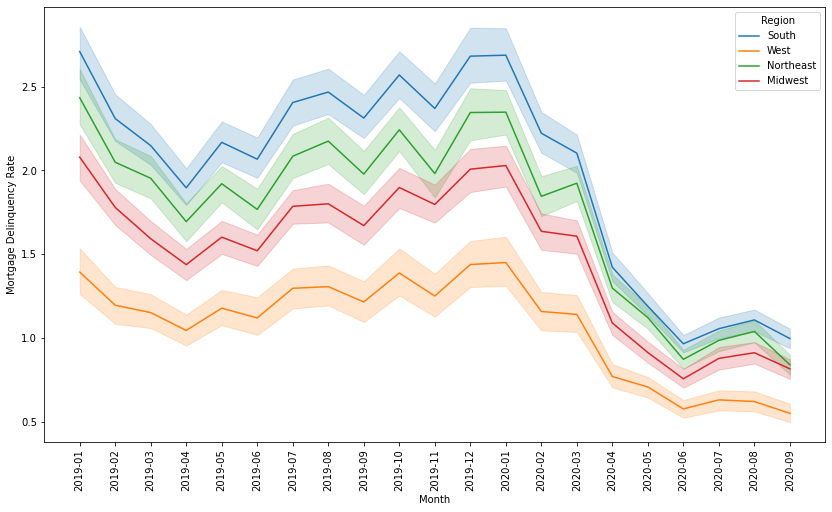

In [118]:
plt.figure(figsize = (14,8))
ax = sns.lineplot(data=df_melted, x="variable", y="value", hue = "Region")
ax.set(xlabel="Month", ylabel = "Mortgage Delinquency Rate")
plt.xticks(rotation=90)

In [106]:
new_df = pd.concat([mortgage_delinq_df.iloc[:,0:25],mortgage_delinq_df['Region']],axis = 1)
new_df_state = new_df.groupby("State").mean()
new_df_state.head()

,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
State,,,,,,,,,,,,,,,,,,,,,
AK,2020.000000,1.500000,1.500000,1.400000,1.300000,1.400000,1.500000,1.800000,1.600000,1.600000,...,1.300000,1.400000,1.600000,1.700000,0.900000,1.100000,0.900000,1.000000,0.900000,0.700000
AL,1085.750000,2.987500,2.725000,2.475000,2.125000,2.287500,2.337500,2.600000,2.800000,2.600000,...,3.075000,3.087500,2.512500,2.487500,1.625000,1.375000,1.125000,1.187500,1.175000,1.075000
AR,5098.500000,2.650000,2.000000,2.100000,1.825000,1.975000,2.050000,2.100000,2.100000,1.800000,...,2.125000,2.400000,2.050000,1.675000,1.325000,1.100000,0.900000,1.000000,1.050000,0.950000
AZ,4020.000000,2.233333,1.883333,1.800000,1.516667,1.650000,1.766667,1.933333,2.150000,1.950000,...,2.183333,2.183333,1.783333,1.800000,1.233333,0.933333,0.783333,0.816667,0.883333,0.833333
CA,6059.263158,1.255263,1.094737,1.126316,1.036842,1.123684,0.973684,1.186842,1.226316,1.128947,...,1.323684,1.352632,1.086842,1.113158,0.760526,0.642105,0.513158,0.571053,0.555263,0.481579


<AxesSubplot:ylabel='State'>

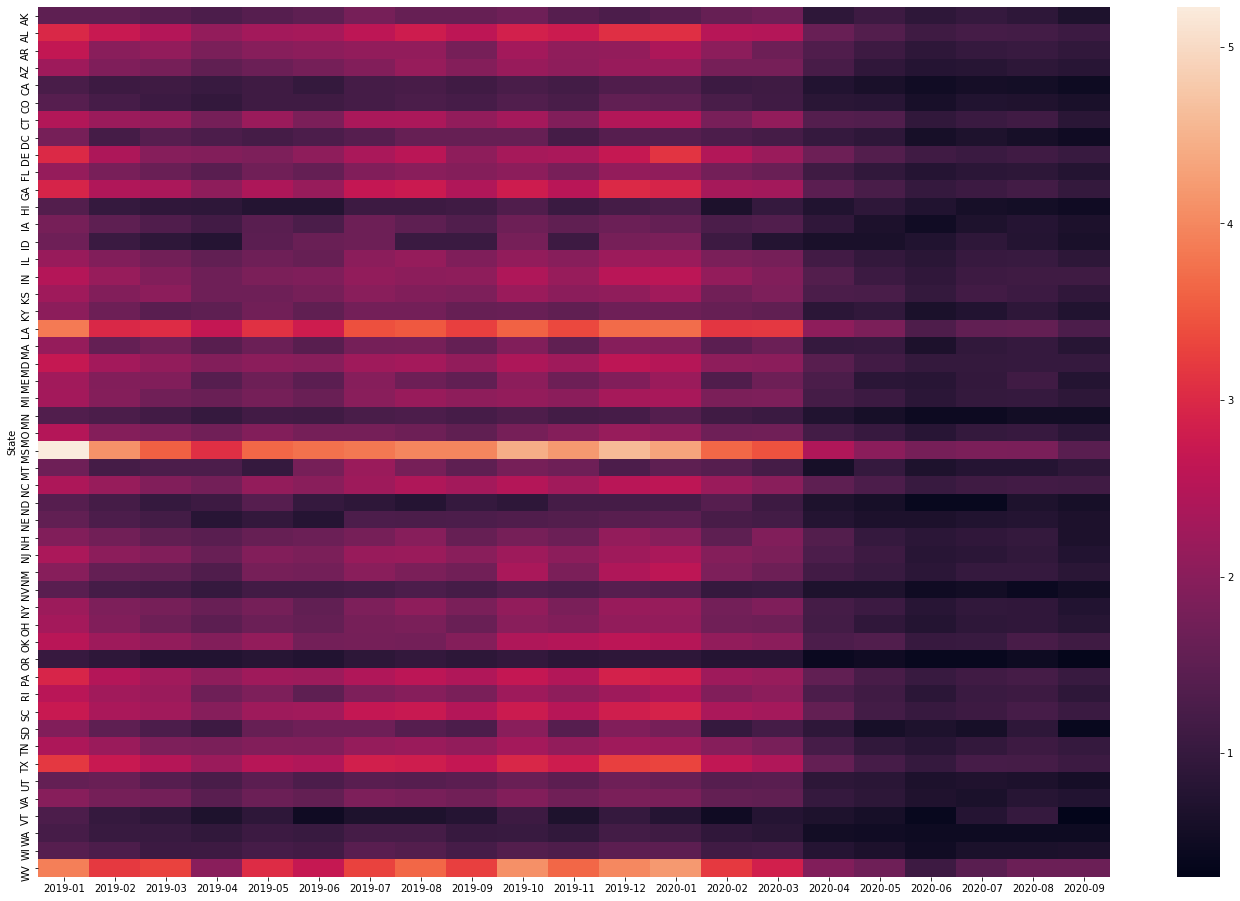

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize = (24,16))

sns.heatmap(new_df_state.iloc[:,1:23])

In [107]:
new_df_region = new_df.groupby("Region").mean()
new_df_region.head()

,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
Region,,,,,,,,,,,,,,,,,,,,,
Midwest,29388.952830,2.079245,1.779245,1.592453,1.437736,1.601887,1.520755,1.785849,1.800943,1.670755,...,2.007547,2.029245,1.636792,1.607547,1.089623,0.913208,0.756604,0.878302,0.912264,0.816038
Northeast,33636.565217,2.433696,2.048913,1.953261,1.694565,1.920652,1.767391,2.084783,2.175000,1.978261,...,2.345652,2.347826,1.845652,1.923913,1.297826,1.121739,0.872826,0.985870,1.039130,0.840217
South,29912.613757,2.709524,2.309524,2.148148,1.896296,2.167725,2.067196,2.405291,2.467725,2.312698,...,2.682011,2.687831,2.222222,2.103175,1.422222,1.189418,0.965608,1.055556,1.107937,0.996825
West,19068.483516,1.393407,1.195604,1.151648,1.045055,1.178022,1.119780,1.296703,1.306593,1.215385,...,1.438462,1.450549,1.158242,1.140659,0.770330,0.707692,0.576923,0.630769,0.620879,0.550549


<AxesSubplot:ylabel='Region'>

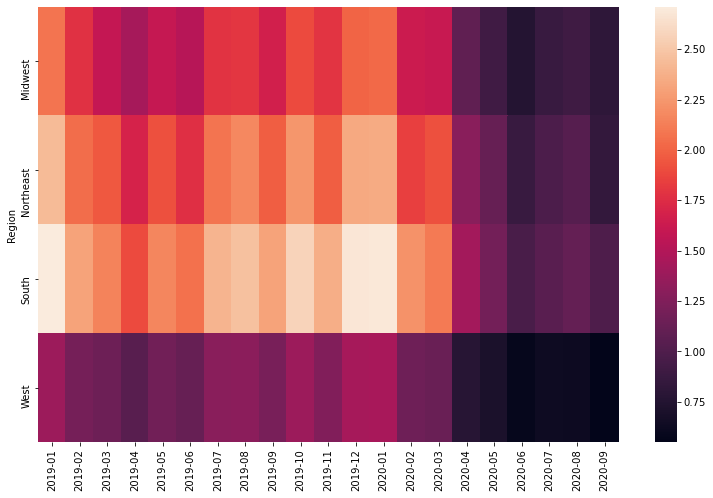

In [111]:
plt.figure(figsize = (13,8))
sns.heatmap(new_df_region.iloc[:,1:23])